In this example we show how a CNN can be used to reconstruct an image from a sinogram using self-supervised learning. 
The CNN takes the back projected image as an input and refines it so that it generates a sinogram (radon transform) that matches the original sinogram.

First we import all necessary modules

In [1]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import DCNN2D
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf


Check if Tensorflow will run on GPU

In [2]:

tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's create a Shepp-Logan phantom

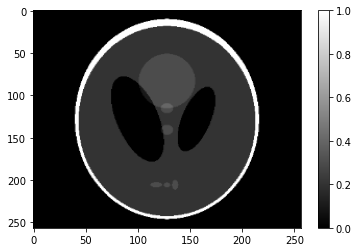

In [3]:
npix = 257
im = SheppLogan(npix)

showim(im, 1, cmap = 'gray')


Calculate the radon transform or sinogram

(1, 257, 257, 1)
(1, 257, 257, 1)


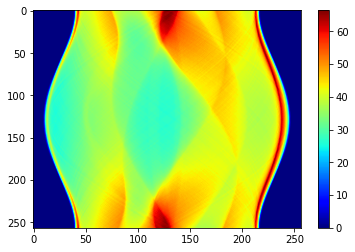

In [4]:
nproj = np.round(npix/1)
theta = tf_create_angles(nproj)

imtf = tf_tomo_transf(im)
print(imtf.shape)

sino = tf_tomo_radon(imtf, theta, interp_method='bilinear')
print(sino.shape)

showim(tf_tomo_squeeze(sino), 2)

Reconstruct using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (257, 257)


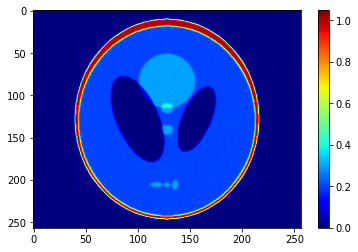

In [5]:
s = np.array(sino[0,:,:,0]).transpose()

fbp = fbpvol(s, theta=np.rad2deg(theta), nt = im.shape[0])
showim(fbp, 3, clim=(0, np.max(fbp)))

Let's create a same size image using random numbers; this image will be used as a starting point for the recontruction neural network

(1, 257, 257, 1)


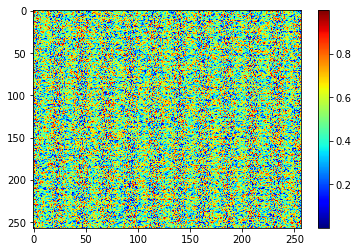

In [6]:

rand = np.random.rand(257,257)
rand = tf_tomo_transf(rand)
print(rand.shape)
showim(rand[0,:,:,0], 2)


Let's create a 2D Autoencoder CNN

In [7]:
model = DCNN2D(npix, nlayers=3, net='autoencoder', dropout='No', batchnorm = 'No', 
                filtnums=64, nconvs=3, actlayerfi = 'linear', skipcon = 'No', dlayer = 'No')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 257, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 257, 257, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 257, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 257, 257, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 129, 129, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 129, 129, 64)      36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 129, 129, 64)      36928 

Now we perform the training of the self-supervised CNN

In [8]:
epochs = 4001
save_interval = 100
lr_interval = 300

optimizer = tf.keras.optimizers.Adam(0.001)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(lr_interval/save_interval),
                                factor=0.5,
                                verbose=1, 
                                optim_lr=optimizer.learning_rate, 
                                reduce_lin=True)

loss = []

reduce_rl_plateau.on_train_begin()

kk = 1
for epoch in tqdm(range(epochs)):

    start = time.time()
    
    with tf.GradientTape(persistent=True) as tape:
        
        generated_img = model(rand)
        
        generated_img = tf.abs(generated_img)
        
        gen_sino = tf_tomo_radon(generated_img, theta, tile=True)

        nnet_loss = ssim_mae_loss(tf.cast(sino, tf.float32), gen_sino)
                
    grad_nnet = tape.gradient(nnet_loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad_nnet, model.trainable_variables))    
    
    loss.append(nnet_loss)

    if epoch % save_interval == 0 and epoch != 0:
            
        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, time.time() - start, nnet_loss))

        reduce_rl_plateau.on_epoch_end(kk, nnet_loss)
    
        kk = kk + 1



  3%|▎         | 103/4001 [00:10<04:54, 13.25it/s]

Time for epoch 1 to 100 is 0.07399988174438477 sec/it - gen_loss = 2.2507684230804443


  5%|▌         | 203/4001 [00:18<05:33, 11.39it/s]

Time for epoch 101 to 200 is 0.08900022506713867 sec/it - gen_loss = 1.0934199094772339


  8%|▊         | 303/4001 [00:26<04:38, 13.30it/s]

Time for epoch 201 to 300 is 0.07199978828430176 sec/it - gen_loss = 0.8475719690322876


 10%|█         | 403/4001 [00:33<04:43, 12.67it/s]

Time for epoch 301 to 400 is 0.07699990272521973 sec/it - gen_loss = 0.6975042819976807


 13%|█▎        | 503/4001 [00:41<04:26, 13.13it/s]

Time for epoch 401 to 500 is 0.07349991798400879 sec/it - gen_loss = 0.6914428472518921


 15%|█▌        | 603/4001 [00:49<04:15, 13.29it/s]

Time for epoch 501 to 600 is 0.07150030136108398 sec/it - gen_loss = 0.5955905914306641


 18%|█▊        | 703/4001 [00:56<04:05, 13.43it/s]

Time for epoch 601 to 700 is 0.07249999046325684 sec/it - gen_loss = 0.5143448114395142


 20%|██        | 803/4001 [01:04<04:03, 13.12it/s]

Time for epoch 701 to 800 is 0.08050036430358887 sec/it - gen_loss = 0.4813489019870758


 23%|██▎       | 903/4001 [01:12<03:57, 13.03it/s]

Time for epoch 801 to 900 is 0.07610750198364258 sec/it - gen_loss = 0.5911231637001038


 25%|██▌       | 1003/4001 [01:19<03:51, 12.97it/s]

Time for epoch 901 to 1000 is 0.07500004768371582 sec/it - gen_loss = 0.29409390687942505


 28%|██▊       | 1103/4001 [01:27<03:40, 13.17it/s]

Time for epoch 1001 to 1100 is 0.07626962661743164 sec/it - gen_loss = 0.32938408851623535


 30%|███       | 1203/4001 [01:34<03:26, 13.57it/s]

Time for epoch 1101 to 1200 is 0.07399964332580566 sec/it - gen_loss = 0.2766878008842468


 33%|███▎      | 1303/4001 [01:42<03:27, 12.98it/s]

Time for epoch 1201 to 1300 is 0.07500004768371582 sec/it - gen_loss = 0.35882630944252014


 35%|███▌      | 1403/4001 [01:50<03:19, 13.03it/s]

Time for epoch 1301 to 1400 is 0.07649993896484375 sec/it - gen_loss = 0.3553391098976135


 38%|███▊      | 1503/4001 [01:57<03:12, 12.99it/s]

Time for epoch 1401 to 1500 is 0.07399821281433105 sec/it - gen_loss = 0.30792921781539917

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


 40%|████      | 1603/4001 [02:05<03:02, 13.12it/s]

Time for epoch 1501 to 1600 is 0.07200002670288086 sec/it - gen_loss = 0.25012725591659546


 43%|████▎     | 1703/4001 [02:13<02:49, 13.55it/s]

Time for epoch 1601 to 1700 is 0.07150006294250488 sec/it - gen_loss = 0.19503116607666016


 45%|████▌     | 1803/4001 [02:20<02:48, 13.04it/s]

Time for epoch 1701 to 1800 is 0.07250308990478516 sec/it - gen_loss = 0.18531832098960876


 48%|████▊     | 1903/4001 [02:28<02:39, 13.17it/s]

Time for epoch 1801 to 1900 is 0.0719914436340332 sec/it - gen_loss = 0.18280720710754395


 50%|█████     | 2003/4001 [02:35<02:34, 12.95it/s]

Time for epoch 1901 to 2000 is 0.07750105857849121 sec/it - gen_loss = 0.19392570853233337


 53%|█████▎    | 2103/4001 [02:43<02:29, 12.68it/s]

Time for epoch 2001 to 2100 is 0.07799959182739258 sec/it - gen_loss = 0.22032611072063446


 55%|█████▌    | 2203/4001 [02:51<02:18, 12.94it/s]

Time for epoch 2101 to 2200 is 0.07444143295288086 sec/it - gen_loss = 0.23525232076644897

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


 58%|█████▊    | 2303/4001 [02:59<02:05, 13.55it/s]

Time for epoch 2201 to 2300 is 0.07199931144714355 sec/it - gen_loss = 0.191423237323761


 60%|██████    | 2403/4001 [03:06<02:03, 12.98it/s]

Time for epoch 2301 to 2400 is 0.07600164413452148 sec/it - gen_loss = 0.1632683426141739


 63%|██████▎   | 2503/4001 [03:14<01:58, 12.69it/s]

Time for epoch 2401 to 2500 is 0.07650065422058105 sec/it - gen_loss = 0.15766632556915283


 65%|██████▌   | 2603/4001 [03:22<01:46, 13.10it/s]

Time for epoch 2501 to 2600 is 0.07600045204162598 sec/it - gen_loss = 0.160276859998703


 68%|██████▊   | 2703/4001 [03:29<01:40, 12.93it/s]

Time for epoch 2601 to 2700 is 0.07800030708312988 sec/it - gen_loss = 0.15099476277828217


 70%|███████   | 2803/4001 [03:37<01:32, 12.92it/s]

Time for epoch 2701 to 2800 is 0.07549881935119629 sec/it - gen_loss = 0.16492816805839539


 73%|███████▎  | 2903/4001 [03:45<01:23, 13.08it/s]

Time for epoch 2801 to 2900 is 0.0755002498626709 sec/it - gen_loss = 0.15800811350345612


 75%|███████▌  | 3003/4001 [03:52<01:16, 13.05it/s]

Time for epoch 2901 to 3000 is 0.07582306861877441 sec/it - gen_loss = 0.16740494966506958

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


 78%|███████▊  | 3103/4001 [04:00<01:08, 13.11it/s]

Time for epoch 3001 to 3100 is 0.0754997730255127 sec/it - gen_loss = 0.14707887172698975


 80%|████████  | 3203/4001 [04:08<01:00, 13.10it/s]

Time for epoch 3101 to 3200 is 0.07299995422363281 sec/it - gen_loss = 0.13925006985664368


 83%|████████▎ | 3303/4001 [04:15<00:53, 13.04it/s]

Time for epoch 3201 to 3300 is 0.07600021362304688 sec/it - gen_loss = 0.14638230204582214


 85%|████████▌ | 3403/4001 [04:23<00:45, 13.25it/s]

Time for epoch 3301 to 3400 is 0.07349824905395508 sec/it - gen_loss = 0.1456521451473236


 88%|████████▊ | 3503/4001 [04:31<00:39, 12.71it/s]

Time for epoch 3401 to 3500 is 0.07599997520446777 sec/it - gen_loss = 0.15327778458595276

Epoch 00036: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


 90%|█████████ | 3603/4001 [04:38<00:30, 13.24it/s]

Time for epoch 3501 to 3600 is 0.07050180435180664 sec/it - gen_loss = 0.1293691098690033


 93%|█████████▎| 3703/4001 [04:46<00:22, 13.09it/s]

Time for epoch 3601 to 3700 is 0.07499885559082031 sec/it - gen_loss = 0.13510577380657196


 95%|█████████▌| 3803/4001 [04:54<00:14, 13.22it/s]

Time for epoch 3701 to 3800 is 0.07599973678588867 sec/it - gen_loss = 0.1306668221950531


 98%|█████████▊| 3903/4001 [05:01<00:07, 13.16it/s]

Time for epoch 3801 to 3900 is 0.0729978084564209 sec/it - gen_loss = 0.0406736396253109


100%|██████████| 4001/4001 [05:09<00:00, 12.94it/s]

Time for epoch 3901 to 4000 is 0.0754997730255127 sec/it - gen_loss = 0.035304147750139236


Let's create now the CNN reconstructed image and compare it with the FBP algorithm

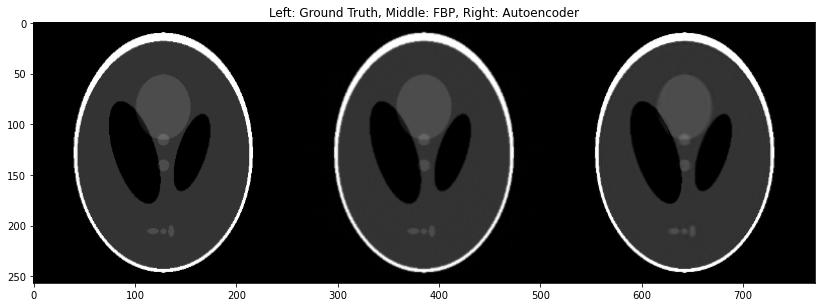

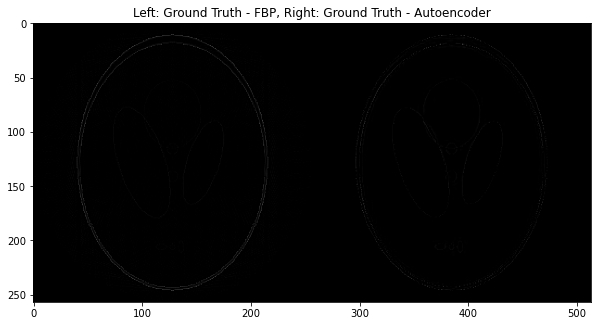

In [9]:
generated_img = model(rand)
generated_img = tf.abs(generated_img)
generated_img = tf_mask_circle(generated_img, npix=0)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: Autoencoder')
plt.show()

plt.figure(2, figsize=(10,10));plt.clf()
plt.imshow(np.concatenate((im - fbp, im - generated_img[0,:,:,0]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth - FBP, Right: Ground Truth - Autoencoder')
plt.show()

Let's calculate some metrics to compare the FBP and CNN reconstructions

In [10]:
imtf = np.reshape(im, (1, im.shape[0], im.shape[1],1))
imfbp = np.reshape(fbp, (1, fbp.shape[0], fbp.shape[1],1))

maeFBP = tf.reduce_mean(tf.keras.losses.MAE(im, fbp)).numpy()
maeCNN = tf.reduce_mean(tf.keras.losses.MAE(im, generated_img[0,:,:,0])).numpy()

mseFBP = tf.reduce_mean(tf.keras.losses.MSE(im, fbp)).numpy()
mseCNN = tf.reduce_mean(tf.keras.losses.MSE(im, generated_img[0,:,:,0])).numpy()

psnrFBP = tf.image.psnr(imtf, imfbp, 1).numpy()
psnrCNN = tf.image.psnr(imtf, generated_img, 1).numpy()

ssimFBP = tf.image.ssim(imtf, imfbp, 1).numpy()
ssimCNN = tf.image.ssim(imtf, np.array(generated_img, dtype='float64'), 1).numpy()

print(maeFBP, maeCNN)
print(mseFBP, mseCNN)
print(psnrFBP, psnrCNN)
print(ssimFBP, ssimCNN)


0.009661197566735464 0.0037950752
0.0007830300505307404 0.00019039011
[31.062214] [37.203556]
[0.95534176] [0.9922626]
